In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [ ]:

data = pd.read_csv('daily_dataset.csv')
columns = ['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max', 'energy_count', 'energy_std', 'energy_sum', 'energy_min']
data.head()


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [ ]:

data = data[columns].apply(pd.to_numeric, errors='coerce')

X = data.drop(['LCLid', 'day'], axis=1)
X.dropna(inplace=True)
X.head()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

In [ ]:
best_n_components = None
lowest_reconstruction_error = float('inf')


In [ ]:
n_components_values = range(100, 1700, 100)
reconstruction_errors = []

Best Number of Components: 1200
Lowest Reconstruction Error: 33.801758266927784


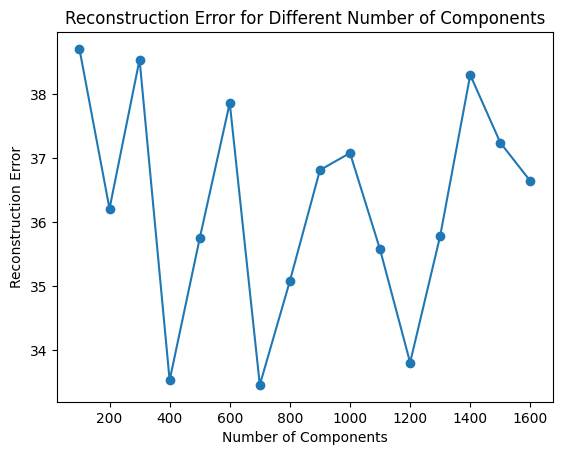

In [ ]:

for n_components in n_components_values:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_scaled)
    reconstructed_data = scaler.inverse_transform(gmm.sample(len(data_scaled))[0])
    reconstruction_error = np.mean(np.square(X.values - reconstructed_data))
    reconstruction_errors.append(reconstruction_error)

    if n_components >= 1000 and n_components <= 1500:  # Check if number of components is within the desired range
        if reconstruction_error < lowest_reconstruction_error:
            lowest_reconstruction_error = reconstruction_error
            best_n_components = n_components

# Print the best number of components and lowest reconstruction error
print("Best Number of Components:", best_n_components)
print("Lowest Reconstruction Error:", lowest_reconstruction_error)

# Plot the reconstruction errors with number of components
plt.plot(n_components_values, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error for Different Number of Components')
plt.show()


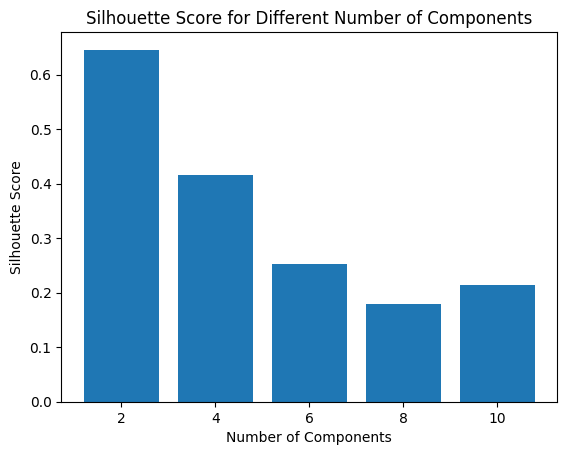

<ipython-input-3-f8f1d5353827>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_representatives = cluster_representatives.append(cluster_data.mean(), ignore_index=True)
<ipython-input-3-f8f1d5353827>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_representatives = cluster_representatives.append(cluster_data.mean(), ignore_index=True)


Silhouette Coefficient: 0.6458
Transmitted Data:
   energy_median  energy_mean  energy_max  energy_count  energy_std  \
0       0.159045     0.230663    0.968159      48.00000    0.209969   
1       0.654561     0.760400    2.435065      47.42025    0.532449   

   energy_sum  energy_min  
0   11.071823    0.049045  
1   36.223128    0.274279  
Data Reduction Accuracy: 99.99%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

data = pd.read_csv('daily_dataset.csv')

columns = ['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max', 'energy_count', 'energy_std', 'energy_sum', 'energy_min']

data = data[columns].apply(pd.to_numeric, errors='coerce')

X = data.drop(['LCLid', 'day'], axis=1)

X.dropna(inplace=True)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

best_n_components = None
best_silhouette = -1

n_components_values = [2, 4, 6, 8, 10]
silhouette_scores = []

for n_components in n_components_values:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_scaled)
    cluster_labels = gmm.predict(data_scaled)

    if len(np.unique(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_components = n_components

plt.bar(range(len(silhouette_scores)), silhouette_scores)
plt.xticks(range(len(n_components_values)), n_components_values)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Components')
plt.show()

gmm = GaussianMixture(n_components=best_n_components)
gmm.fit(data_scaled)
cluster_labels = gmm.predict(data_scaled)

data['cluster_label'] = np.nan
data.loc[X.index, 'cluster_label'] = cluster_labels

unique_labels = np.unique(cluster_labels)
cluster_representatives = pd.DataFrame(columns=columns[2:])
for label in unique_labels:
    cluster_data = data.loc[data['cluster_label'] == label].drop(['LCLid', 'day', 'cluster_label'], axis=1)
    cluster_representatives = cluster_representatives.append(cluster_data.mean(), ignore_index=True)

transmitted_data = cluster_representatives

silhouette_avg = silhouette_score(data_scaled, cluster_labels)

print("Silhouette Coefficient: {:.4f}".format(silhouette_avg))

original_data_size = len(data) * len(data.columns)
transmitted_data_size = len(transmitted_data) * len(transmitted_data.columns)
data_reduction = 100 * (1 - transmitted_data_size / original_data_size)

print("Transmitted Data:")
print(transmitted_data)
print("Data Reduction Accuracy: {:.2f}%".format(data_reduction))


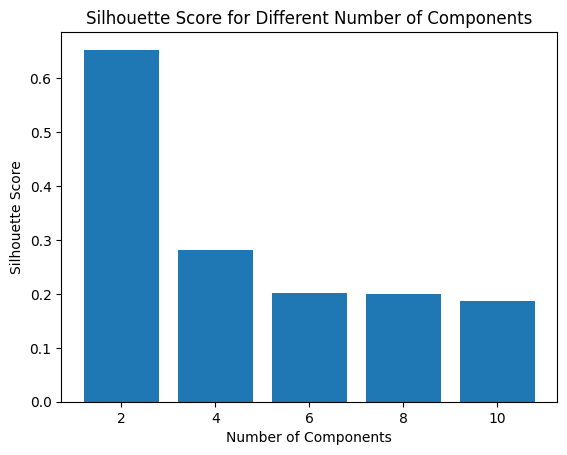

ValueError: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


data = pd.read_csv('daily_dataset.csv')


columns = ['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max', 'energy_count', 'energy_std', 'energy_sum', 'energy_min']


data = data[columns].apply(pd.to_numeric, errors='coerce')

X = data.drop(['LCLid', 'day'], axis=1)

X.dropna(inplace=True)


scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)


best_n_components = None
best_silhouette = -1


n_components_values = [2, 4, 6, 8, 10]
silhouette_scores = []


for n_components in n_components_values:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_scaled)
    cluster_labels = gmm.predict(data_scaled)

    if len(np.unique(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_components = n_components


plt.bar(range(len(silhouette_scores)), silhouette_scores)
plt.xticks(range(len(n_components_values)), n_components_values)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Components')
plt.show()


gmm = GaussianMixture(n_components=best_n_components)
gmm.fit(data_scaled)
cluster_labels = gmm.predict(data_scaled)


data['cluster_label'] = cluster_labels

unique_labels = np.unique(cluster_labels)
cluster_representatives = pd.DataFrame(columns=columns[2:])
for label in unique_labels:
    cluster_data = data.loc[data['cluster_label'] == label].drop(['LCLid', 'day', 'cluster_label'], axis=1)
    cluster_representatives = cluster_representatives.append(cluster_data.mean(), ignore_index=True)


transmitted_data = cluster_representatives


silhouette_avg = silhouette_score(data_scaled, cluster_labels)


print("Silhouette Coefficient: {:.4f}".format(silhouette_avg))


original_data_size = len(data) * len(data.columns)
transmitted_data_size = len(transmitted_data) * len(transmitted_data.columns)
data_reduction = 100 * (1 - transmitted_data_size / original_data_size)


print("Transmitted Data:")
print(transmitted_data)
print("Data Reduction Accuracy: {:.2f}%".format(data_reduction))


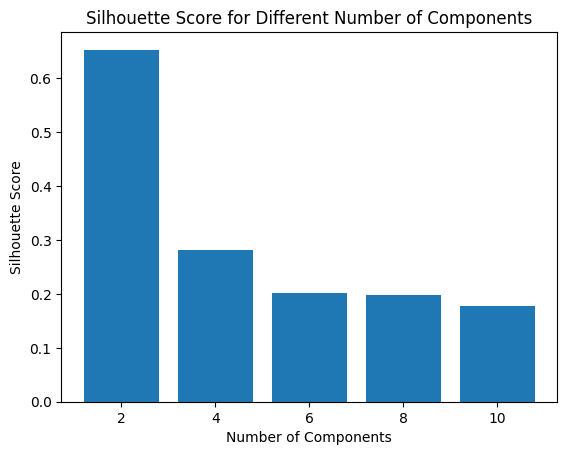

<ipython-input-2-29d5c9bb212b>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_representatives = cluster_representatives.append(cluster_data.mean(), ignore_index=True)
<ipython-input-2-29d5c9bb212b>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_representatives = cluster_representatives.append(cluster_data.mean(), ignore_index=True)


Silhouette Coefficient: 0.6528


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


data = pd.read_csv('daily_dataset.csv')


columns = ['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max', 'energy_count', 'energy_std', 'energy_sum', 'energy_min']


data = data[columns].apply(pd.to_numeric, errors='coerce')


X = data.drop(['LCLid', 'day'], axis=1)


X.dropna(inplace=True)


scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)


best_n_components = None
best_silhouette = -1


n_components_values = [2, 4, 6, 8, 10]
silhouette_scores = []


for n_components in n_components_values:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_scaled)
    cluster_labels = gmm.predict(data_scaled)

    if len(np.unique(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_n_components = n_components


plt.bar(range(len(silhouette_scores)), silhouette_scores)
plt.xticks(range(len(n_components_values)), n_components_values)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Components')
plt.show()


gmm = GaussianMixture(n_components=best_n_components)
gmm.fit(data_scaled)
cluster_labels = gmm.predict(data_scaled)


data['cluster_label'] = np.nan
data.loc[X.index, 'cluster_label'] = cluster_labels


unique_labels = np.unique(cluster_labels)
cluster_representatives = pd.DataFrame(columns=columns[2:])
for label in unique_labels:
    cluster_data = data.loc[data['cluster_label'] == label].drop(['LCLid', 'day', 'cluster_label'], axis=1)
    cluster_representatives = cluster_representatives.append(cluster_data.mean(), ignore_index=True)

transmitted_data = cluster_representatives


silhouette_avg = silhouette_score(data_scaled, cluster_labels)


print("Silhouette Coefficient: {:.4f}".format(silhouette_avg))

original_data_size = len(data) * len(data.columns)
transmitted_data_size = len
